## Named Entity Recognition

Experiments will involve application of a transformer model for NER task.
Brief survey indicated that for the task at hand, xlm-roberta-large-ner-hrl model will be the most suitable. It is a NER model for 10 high resource languages, including Latvian, based on fine-tuned XLM-RoBERTa large model, and trained to extract three entity types - locations, organizations and persons.
See reference for the source of the model and initial source code.

Reference:
https://huggingface.com/Davlan/xlm-roberta-large-ner-hrl/tree/main

In [ ]:
# ! pip install transformers sentencepiece protobuf pandas

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("Davlan/xlm-roberta-large-ner-hrl")
model = AutoModelForTokenClassification.from_pretrained("Davlan/xlm-roberta-large-ner-hrl") # the model is loaded. Warning: it is over 2GB large
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first") # the pipeline is created


Using pipeline from HuggingFace, a definition was created to find all of  

In [3]:
import pandas as pd
import os

nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

def extract_entities(file_path):
    entities_dict = {entity_type: [] for entity_type in ["LOC", "PER", "ORG"]}
    entity_counters = {entity_type: 0 for entity_type in entities_dict}

    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()  # Read all lines into memory
        batch_size = 10  # Define batch size

        for i in range(0, len(lines), batch_size):
            batch = lines[i:i + batch_size]

            line_results = nlp(batch)

            for line_result in line_results:
                for entity in line_result:
                    if "entity_group" in entity and entity["entity_group"] in entities_dict:
                        entities_dict[entity["entity_group"]].append(entity["word"])
                        entity_counters[entity["entity_group"]] += 1

    max_length = max(len(entities) for entities in entities_dict.values())

    for entities in entities_dict.values():
        while len(entities) < max_length:
            entities.append(None)

    return entities_dict, entity_counters

def create_ne_corpus(corpus_root):
    ne_corpus = []

    for filename in os.listdir(corpus_root):
        file_path = os.path.join(corpus_root, filename)

        entities_dict, entity_counters = extract_entities(file_path)

        ne_corpus.append({
            'Filename': filename,
            **entity_counters
        })

    ne_df = pd.DataFrame(ne_corpus)

    return ne_df

corpus_root = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Data\Corpus"
ne_corpus = create_ne_corpus(corpus_root)
print(ne_corpus)

C:\Users\papel\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


                                             Filename  LOC  PER  ORG
0            1115688_Karla-Valguma-dienasgramatas.txt  323  717   76
1           1115696_Edgara-Reinsona-dienasgramata.txt   97   14    0
2           1117599_Irmas-Viksninas-dienasgramata.txt  101  793    5
3   1117599_nezinamas-rigas-skolnieces-dienasgrama...  101  793    5
4      1117608_Dainas-Rozenblates-Atminu-zimejumi.txt  267  717   41
..                                                ...  ...  ...  ...
90                   1797583_Karla-Sabaka-atminas.txt    9    9    5
91  1799971_Izraksti-no-Karla-Paucisa-dienasgramat...   52  456  110
92  1846318_Katrines-Butenieces-dienasgramata-no-1...  427  510   20
93  1900122_Karla-Vesmana-vestules-un-Annas-Rosman...  453  381   68
94                    1910061_Olgas-Veges-atminas.txt    0    0    0

[95 rows x 4 columns]


In [4]:
ne_corpus.to_csv("ne_corpus.csv", index=False)

In [2]:
short_texts = []
short_texts.extend(["1135846_Nezinama-viriesa-dienasgramata-ar-nosaukumu-Daba.txt",
                   "1214933_Celojums-pa-6-republikam-Dienasgramata.txt", 
                   "1135459_Paula-Alksna-pieraksti-un-darba-zurnali.txt",
                   "1247401_Annas-Vagales-atminas.txt",
                   "1276664_Dienasgramata-Vecsetu-muizas-kases-gramata.txt", 
                   "1689421_Alidas-Kigules-vestules.txt", 
                   "1910061_Olgas-Veges-atminas.txt", 
                   "1247269_Alfreda-Krumina-dienasgramatas.txt", 
                   "1133883_Augusta-Heinrihsona-dzivesstasts.txt",
                   "1146801_Ulda-Kirsa-dzive-laukos-Tvitera-dienasgramata.txt"])
print(short_texts)

['1135846_Nezinama-viriesa-dienasgramata-ar-nosaukumu-Daba.txt', '1214933_Celojums-pa-6-republikam-Dienasgramata.txt', '1135459_Paula-Alksna-pieraksti-un-darba-zurnali.txt', '1247401_Annas-Vagales-atminas.txt', '1276664_Dienasgramata-Vecsetu-muizas-kases-gramata.txt', '1689421_Alidas-Kigules-vestules.txt', '1910061_Olgas-Veges-atminas.txt', '1247269_Alfreda-Krumina-dienasgramatas.txt', '1133883_Augusta-Heinrihsona-dzivesstasts.txt', '1146801_Ulda-Kirsa-dzive-laukos-Tvitera-dienasgramata.txt']


In [8]:
import csv

def calculate_entity_frequencies(input_csv, total_tokens_csv, short_texts):
    ne_freq = pd.DataFrame(columns=['Filename', 'Location', 'Person', 'Organization'])
    
    total_tokens = {}
    with open(total_tokens_csv, 'r', newline='', encoding='utf-8') as total_file:
        total_reader = csv.reader(total_file)
        next(total_reader)  
        for row in total_reader:
            filename, _, total_count, _ = row  # Taking only the filename and total count
            total_tokens[filename] = int(total_count) # Storing the total count in the dictionary
    
    with open(input_csv, 'r', newline='', encoding='utf-8') as input_file:
        input_reader = csv.reader(input_file)
        next(input_reader)  
        for row in input_reader: # loop for going through each row in the input csv
            filename, loc, per, org = row[0], row[1], row[2], row[3]
            
            if filename in short_texts:
                continue  # Skip processing if filename is in short_texts
            
            total_count = total_tokens.get(filename, 1)  # Avoid division by zero
            if total_count == 0:
                continue  # There are empty rows, so they will be skipped
            
            loc_freq = int(loc) / total_count
            per_freq = int(per) / total_count
            org_freq = int(org) / total_count
            
            freq_data = pd.DataFrame({'Filename': [filename],
                                     'Location': [loc_freq],
                                     'Person': [per_freq],
                                     'Organization': [org_freq]})
            
            freq_data = freq_data.dropna(axis=1, how='all') # Drop columns with all NaN values
            
            ne_freq = pd.concat([ne_freq, freq_data], ignore_index=True)
    
    return ne_freq

input_csv = "C:/Users/papel/GitHub_Projects/NER-for-Autobiography-collection/NER-experiments/ne_corpus.csv"
total_tokens_csv = "C:/Users/papel/GitHub_Projects/NER-for-Autobiography-collection/NER-experiments/token_results_df.csv"

ne_freq = calculate_entity_frequencies(input_csv, total_tokens_csv, short_texts) # Calculate entity frequencies
ne_freq = round(ne_freq,6) # Values will be rounded to six decimal places
ne_freq.to_csv("ne_freq.csv", index=False)
print(ne_freq)


                                             Filename  Location    Person  \
0            1115688_Karla-Valguma-dienasgramatas.txt  0.019613  0.043536   
1           1115696_Edgara-Reinsona-dienasgramata.txt  0.013993  0.002020   
2           1117599_Irmas-Viksninas-dienasgramata.txt  0.006247  0.049048   
3   1117599_nezinamas-rigas-skolnieces-dienasgrama...  0.006247  0.049048   
4      1117608_Dainas-Rozenblates-Atminu-zimejumi.txt  0.005354  0.014378   
..                                                ...       ...       ...   
80                   1690857_Valda-Skeles-atminas.txt  0.076336  0.026718   
81                   1797583_Karla-Sabaka-atminas.txt  0.017787  0.017787   
82  1799971_Izraksti-no-Karla-Paucisa-dienasgramat...  0.005434  0.047649   
83  1846318_Katrines-Butenieces-dienasgramata-no-1...  0.009309  0.011118   
84  1900122_Karla-Vesmana-vestules-un-Annas-Rosman...  0.031678  0.026643   

    Organization  
0       0.004615  
1       0.000000  
2       0.000309  

C:\Users\papel\AppData\Local\Temp\ipykernel_34308\335999161.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ne_freq = pd.concat([ne_freq, freq_data], ignore_index=True)


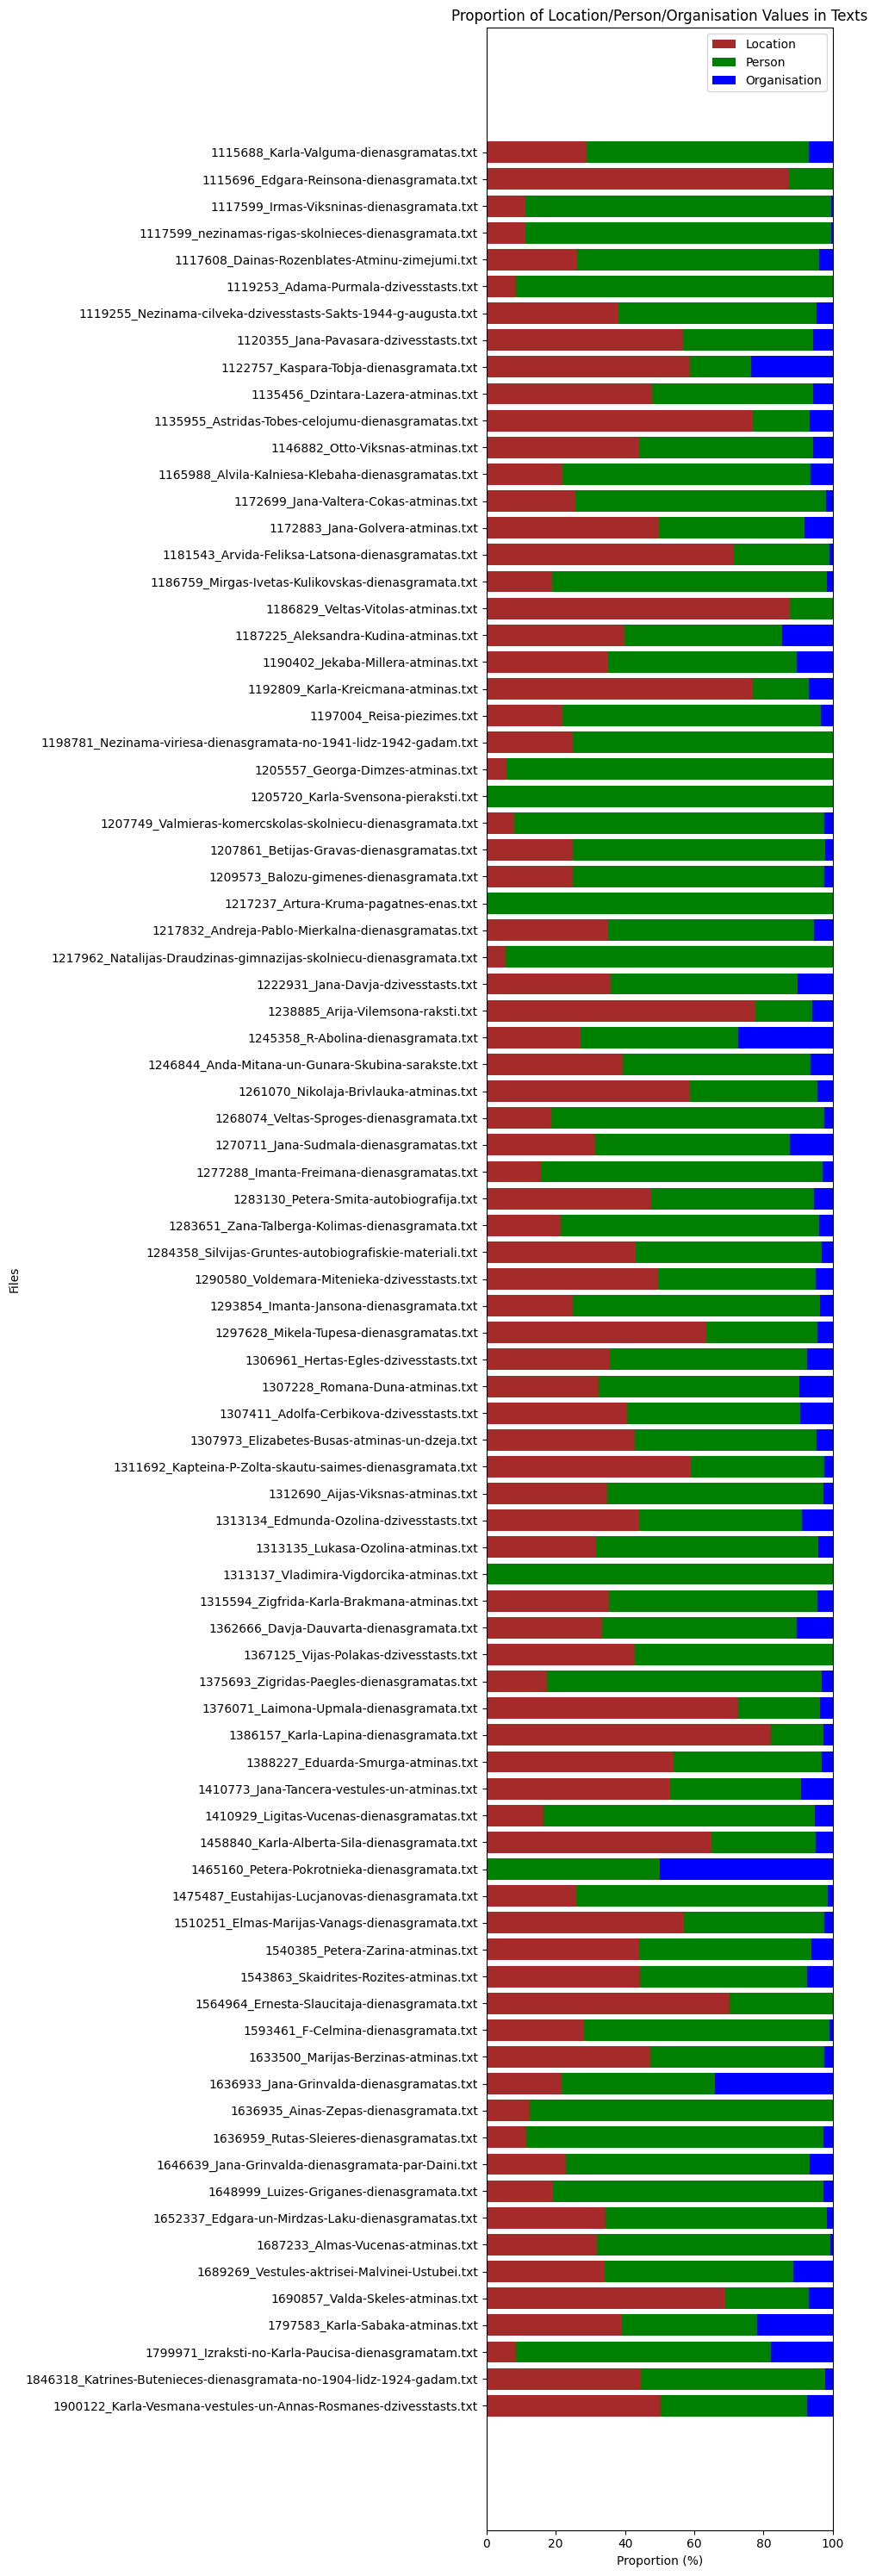

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

ne_freq = ne_freq[::-1].reset_index(drop=True)  # Reversing the order of rows

plt.figure(figsize=(10, 30))  

colors = ['brown', 'green', 'blue']

for i, row in ne_freq.iterrows():
    total_count = row['Location'] + row['Person'] + row['Organization']
    
    #if total_count == 0:      # Not neccessrary after introduction of the short_texts variable
        #loc_percentage = 0
        #per_percentage = 0
        #org_percentage = 0
#else:
    loc_percentage = row['Location'] / total_count * 100
    per_percentage = row['Person'] / total_count * 100
    org_percentage = row['Organization'] / total_count * 100
    
    # Plot bars in the original order
    plt.barh(i, loc_percentage, color=colors[0], label='Location' if i == 0 else None)
    plt.barh(i, per_percentage, left=loc_percentage, color=colors[1], label='Person' if i == 0 else None)
    plt.barh(i, org_percentage, left=loc_percentage + per_percentage, color=colors[2], label='Organisation' if i == 0 else None)

# Add labels and title
plt.xlabel('Proportion (%)')
plt.ylabel('Files')
plt.yticks(range(len(ne_freq)), ne_freq['Filename'])
plt.title('Proportion of Location/Person/Organisation Values in Texts')

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


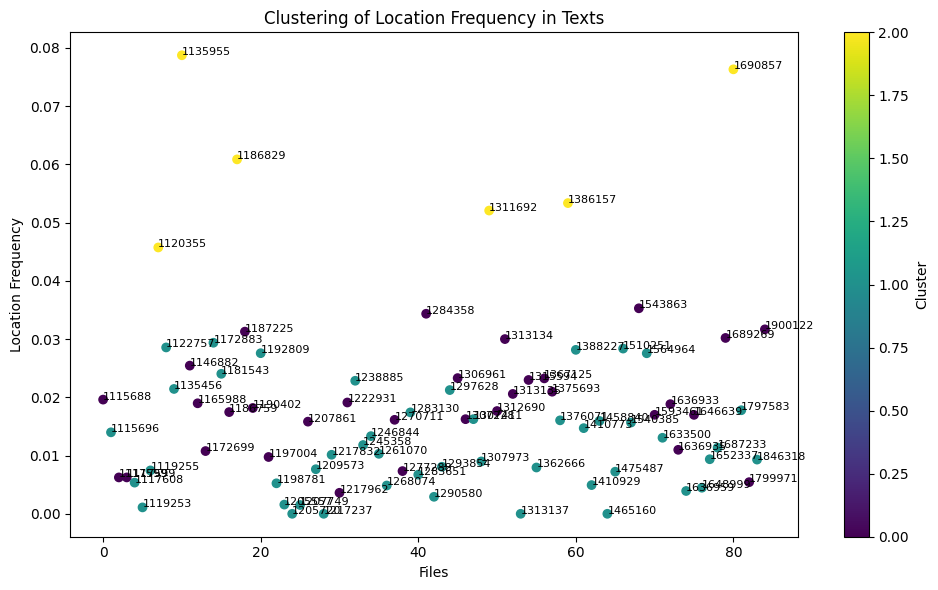

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming ne_freq contains the DataFrame with the data

# Extract features from the DataFrame
X = ne_freq[['Location', 'Person', 'Organization']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming you want to cluster into 3 groups
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
ne_freq['Cluster'] = clusters

# Visualize the clustering results
plt.figure(figsize=(10, 6))

# Scatter plot of the 'Location' column
plt.scatter(ne_freq.index, ne_freq['Location'], c=ne_freq['Cluster'], cmap='viridis')

# Add labels to each point
for i, filename in enumerate(ne_freq['Filename']):
    # Take only the first part until the underscore (_) for labeling
    label = filename.split('_')[0]
    plt.text(ne_freq.index[i], ne_freq['Location'][i], label, fontsize=8)

# Add labels and title
plt.xlabel('Files')
plt.ylabel('Location Frequency')
plt.title('Clustering of Location Frequency in Texts')

# Show color bar
plt.colorbar(label='Cluster')

# Show plot
plt.tight_layout()
plt.show()


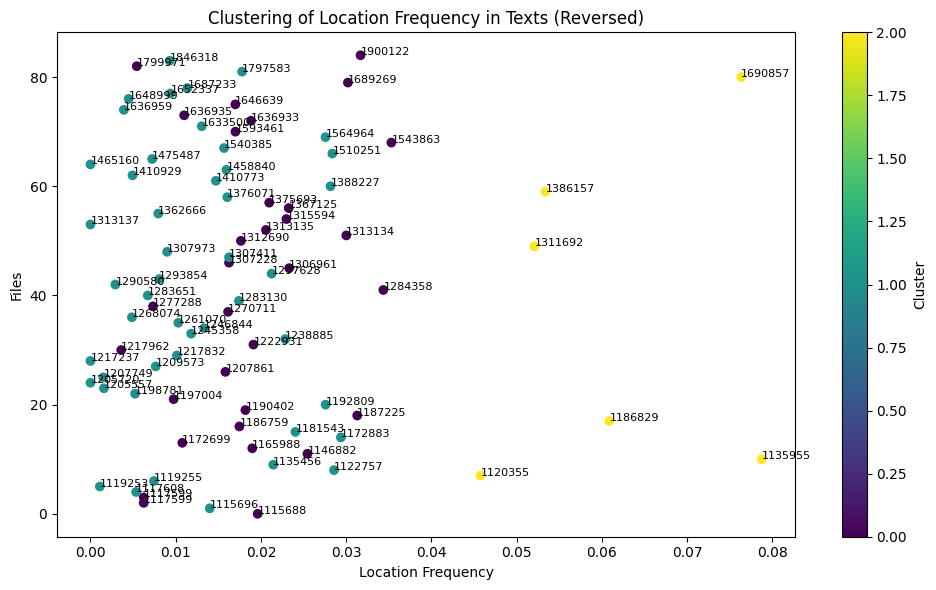

In [23]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming ne_freq contains the DataFrame with the data

# Extract features from the DataFrame
X = ne_freq[['Location', 'Person', 'Organization']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming you want to cluster into 3 groups
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
ne_freq['Cluster'] = clusters

# Visualize the clustering results
plt.figure(figsize=(10, 6))

# Scatter plot with reversed axes
plt.scatter(ne_freq['Location'], ne_freq.index, c=ne_freq['Cluster'], cmap='viridis')

# Add labels to each point
for i, filename in enumerate(ne_freq['Filename']):
    # Take only the first part until the underscore (_) for labeling
    label = filename.split('_')[0]
    plt.text(ne_freq['Location'][i], ne_freq.index[i], label, fontsize=8)

# Add labels and title
plt.xlabel('Location Frequency')
plt.ylabel('Files')
plt.title('Clustering of Location Frequency in Texts (Reversed)')

# Show color bar
plt.colorbar(label='Cluster')

# Show plot
plt.tight_layout()
plt.show()


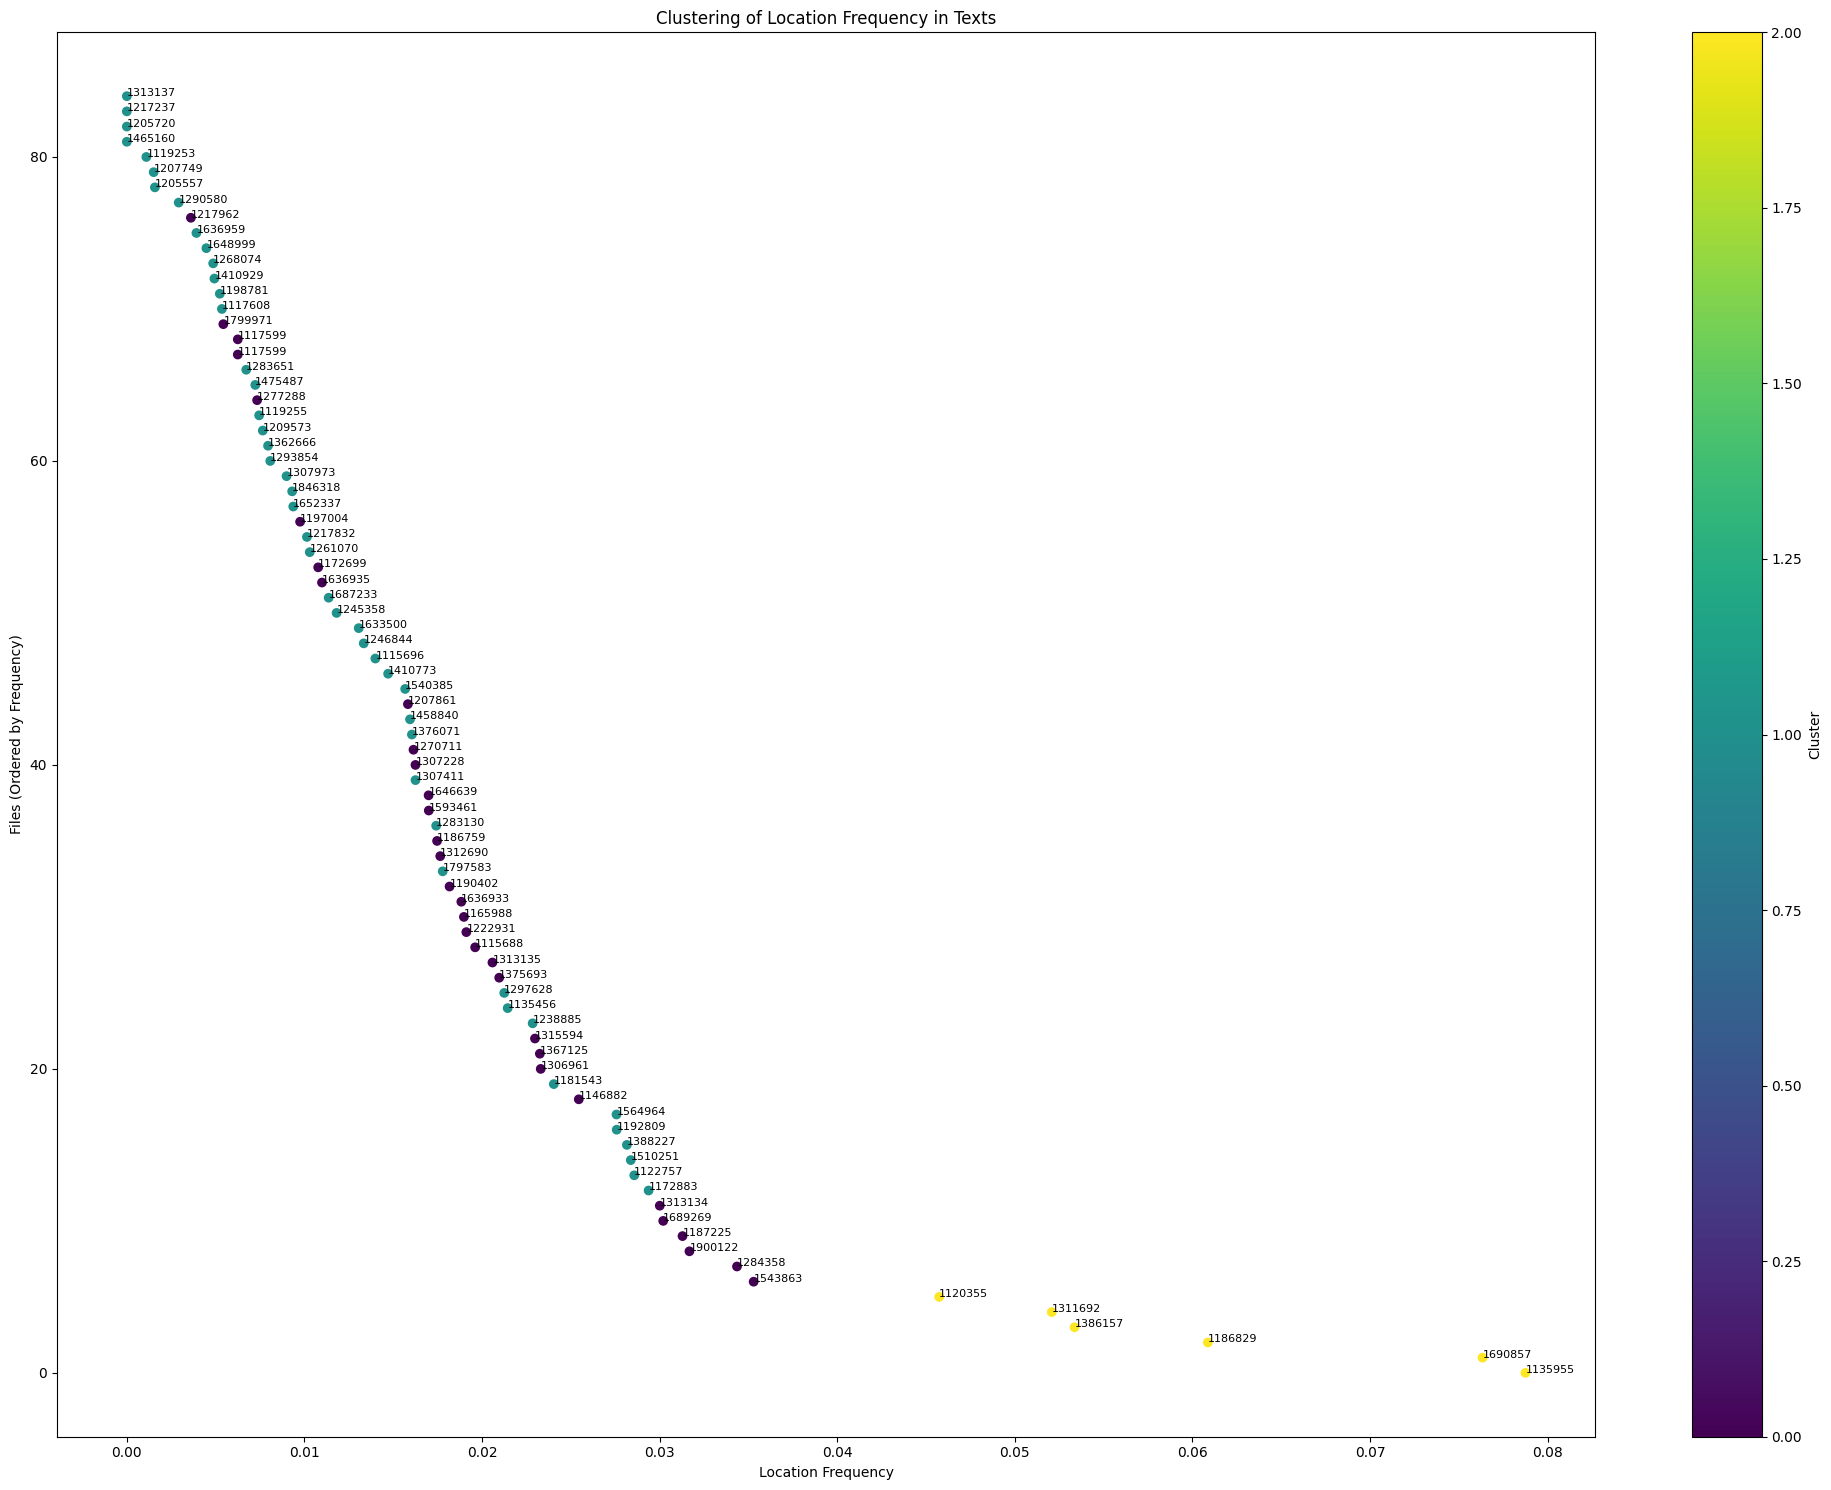

In [26]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming ne_freq contains the DataFrame with the data

# Extract features from the DataFrame
X = ne_freq[['Location', 'Person', 'Organization']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming you want to cluster into 3 groups
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
ne_freq['Cluster'] = clusters

# Sort DataFrame based on 'Location' frequency
ne_freq_sorted = ne_freq.sort_values(by='Location', ascending=False)

# Visualize the clustering results
plt.figure(figsize=(20, 15))

# Scatter plot
plt.scatter(ne_freq_sorted['Location'], range(len(ne_freq_sorted)), c=ne_freq_sorted['Cluster'], cmap='viridis')

# Add labels to each point
for i, filename in enumerate(ne_freq_sorted['Filename']):
    # Take only the first part until the underscore (_) for labeling
    label = filename.split('_')[0]
    plt.text(ne_freq_sorted['Location'].iloc[i], i, label, fontsize=8)

# Add labels and title
plt.xlabel('Location Frequency')
plt.ylabel('Files (Ordered by Frequency)')
plt.title('Clustering of Location Frequency in Texts')

# Show color bar
plt.colorbar(label='Cluster')

# Show plot
plt.tight_layout()
plt.show()


In [29]:
gender_metadata_file = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\NER-experiments\gender_cat.csv"

with open(gender_metadata_file, 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    gender_data = list(reader)

gender_df = pd.DataFrame(gender_data)

ne_freq_cat = pd.merge(ne_freq, gender_df, on='Filename')

print(ne_freq_cat) 

                                             Filename  Location    Person  \
0            1115688_Karla-Valguma-dienasgramatas.txt  0.019613  0.043536   
1           1115696_Edgara-Reinsona-dienasgramata.txt  0.013993  0.002020   
2           1117599_Irmas-Viksninas-dienasgramata.txt  0.006247  0.049048   
3   1117599_nezinamas-rigas-skolnieces-dienasgrama...  0.006247  0.049048   
4      1117608_Dainas-Rozenblates-Atminu-zimejumi.txt  0.005354  0.014378   
..                                                ...       ...       ...   
80                   1690857_Valda-Skeles-atminas.txt  0.076336  0.026718   
81                   1797583_Karla-Sabaka-atminas.txt  0.017787  0.017787   
82  1799971_Izraksti-no-Karla-Paucisa-dienasgramat...  0.005434  0.047649   
83  1846318_Katrines-Butenieces-dienasgramata-no-1...  0.009309  0.011118   
84  1900122_Karla-Vesmana-vestules-un-Annas-Rosman...  0.031678  0.026643   

    Organization Category  
0       0.004615     Male  
1       0.000000   

In [31]:
import pandas as pd

# Assuming ne_freq_cat is your existing DataFrame with the structure as shown
# Calculate average frequencies by category
ne_freq_cattotal = ne_freq_cat.groupby('Category')[['Location', 'Person', 'Organization']].mean()

# Reset index to make 'Category' a regular column
ne_freq_cattotal.reset_index(inplace=True)

# Print the resulting DataFrame
print(ne_freq_cattotal)


     Category  Location    Person  Organization
0  Collective  0.013903  0.029000      0.001083
1      Female  0.018879  0.033408      0.001554
2        Male  0.017738  0.021562      0.003701
3       Other  0.030940  0.037371      0.007411


Analysis of first Target file.

In [2]:
from transformers import pipeline
from docx import Document as DocxDocument
import docx.shared
import pandas as pd

# Initialize NER pipeline
pipeline_first = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

# Load text file
file_path = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Data\Corpus\1386157_Karla-Lapina-dienasgramata.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_lines = file.readlines()

# Defining colors for each entity type
entity_colors = {
    "LOC": "75a65d",  # Light Green
    "PER": "0000FF",  # Blue
    "ORG": "FF0000"   # Red
}
doc = DocxDocument()

# Counters will help to understant if all entities are processed; for the final report this may not be necessary
entity_counters = {entity_type: 0 for entity_type in entity_colors.keys()}

# List to store entities; important for storing the data for manual work
entity_data = []

# Main loop to process text and colorize entities
for line in text_lines:
    paragraph = doc.add_paragraph()
    last_entity_end = 0  # Tracking of the end index of the last entity

    # Getting of the entities for the current line
    line_results = pipeline_first(line.strip())

    if line_results:
        for idx, entity in enumerate(line_results):
            entity_start_index = entity["start"]
            entity_end_index = entity["end"]
            entity_text = entity["word"]
            entity_type = entity["entity_group"]
            color = entity_colors.get(entity_type, "000000")  # Default color to black if not specified

            # Add non-entity text between entities
            non_entity_text = line[last_entity_end:entity_start_index]
            if non_entity_text:
                paragraph.add_run(non_entity_text + " ")

            # Add the entity with colorization and bold font
            run = paragraph.add_run(entity_text)
            run.font.color.rgb = docx.shared.RGBColor(int(color[:2], 16),
                                                      int(color[2:4], 16),
                                                      int(color[4:], 16))
            run.bold = True  # Set bold font for entity

            # Add entity type after entity in smaller font
            entity_type_run = paragraph.add_run(f" {entity_type.upper()}")
            entity_type_run.font.size = docx.shared.Pt(8)
            entity_type_run.font.bold = True

            # Update entity counters
            entity_counters[entity_type] += 1

            # Update last_entity_end index
            last_entity_end = entity_end_index

            # Append entity data for the current line
            entity_data.append([entity_text, entity_type.upper(), "", ""])  # Added empty columns for Correct NE and Comment

            # Add whitespace after entity type if it's not the last one in the line
            if idx < len(line_results) - 1:
                paragraph.add_run(" ")

        # Adding any remaining non-entity text after the last entity
        if last_entity_end < len(line):
            remaining_text = line[last_entity_end:]
            paragraph.add_run(remaining_text)
    else:
        paragraph.add_run(line)  # If no entities are found, line will be saved as it is

# Save the document
output_file_path = "1386157_corpusfile_labeled.docx"
doc.save(output_file_path)
print("Output saved as 'corpusfile_labeled.docx'.")

# Converting entity data to DataFrame
df = pd.DataFrame(entity_data, columns=["NE", "Type", "Correct NE", "Comment"])  # Last two columns are for manual corrections

# Write data to Excel file with XlsxWriter engine
output_excel_path = "1386157_entities_workfile.xlsx"
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    # Write data to first sheet
    df.to_excel(writer, index=False, sheet_name='Extracted Entities')
    
    # Second sheet with empty columns for manually identified NEs
    empty_df = pd.DataFrame(columns=["NE", "Type", "Comment"])  
    empty_df.to_excel(writer, index=False, sheet_name='Manual NEs')

print("Entity Counters:")
for entity_type, count in entity_counters.items():
    print(f"{entity_type}: {count}")

print(f"Entities saved to '{output_excel_path}' Excel file.")


c:\Program Files\Python312\Lib\site-packages\transformers\pipelines\token_classification.py:393: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


Output saved as 'corpusfile_labeled.docx'.
Entity Counters:
LOC: 119
PER: 22
ORG: 4
Entities saved to '1386157_entities_workfile.xlsx' Excel file.


Second target text

In [5]:
from transformers import pipeline
from docx import Document as DocxDocument
import docx.shared
import pandas as pd

# Initialize NER pipeline
pipeline_first = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

# Load text file
file_path = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Data\Corpus\1192809_Karla-Kreicmana-atminas.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_lines = file.readlines()

# Defining colors for each entity type
entity_colors = {
    "LOC": "75a65d",  # Light Green
    "PER": "0000FF",  # Blue
    "ORG": "FF0000"   # Red
}
doc = DocxDocument()

# Counters will help to understant if all entities are processed; for the final report this may not be necessary
entity_counters = {entity_type: 0 for entity_type in entity_colors.keys()}

# List to store entities; important for storing the data for manual work
entity_data = []

# Main loop to process text and colorize entities
for line in text_lines:
    paragraph = doc.add_paragraph()
    last_entity_end = 0  # Tracking of the end index of the last entity

    # Getting of the entities for the current line
    line_results = pipeline_first(line.strip())

    if line_results:
        for idx, entity in enumerate(line_results):
            entity_start_index = entity["start"]
            entity_end_index = entity["end"]
            entity_text = entity["word"]
            entity_type = entity["entity_group"]
            color = entity_colors.get(entity_type, "000000")  # Default color to black if not specified

            # Add non-entity text between entities
            non_entity_text = line[last_entity_end:entity_start_index]
            if non_entity_text:
                paragraph.add_run(non_entity_text + " ")

            # Add the entity with colorization and bold font
            run = paragraph.add_run(entity_text)
            run.font.color.rgb = docx.shared.RGBColor(int(color[:2], 16),
                                                      int(color[2:4], 16),
                                                      int(color[4:], 16))
            run.bold = True  # Set bold font for entity

            # Add entity type after entity in smaller font
            entity_type_run = paragraph.add_run(f" {entity_type.upper()}")
            entity_type_run.font.size = docx.shared.Pt(8)
            entity_type_run.font.bold = True

            # Update entity counters
            entity_counters[entity_type] += 1

            # Update last_entity_end index
            last_entity_end = entity_end_index

            # Append entity data for the current line
            entity_data.append([entity_text, entity_type.upper(), "", ""])  # Added empty columns for Correct NE and Comment

            # Add whitespace after entity type if it's not the last one in the line
            if idx < len(line_results) - 1:
                paragraph.add_run(" ")

        # Adding any remaining non-entity text after the last entity
        if last_entity_end < len(line):
            remaining_text = line[last_entity_end:]
            paragraph.add_run(remaining_text)
    else:
        paragraph.add_run(line)  # If no entities are found, line will be saved as it is

# Save the document
output_file_path = "1192809_corpusfile_labeled.docx"
doc.save(output_file_path)
print("Output saved as '1192809_corpusfile_labeled.docx'.")

# Converting entity data to DataFrame
df = pd.DataFrame(entity_data, columns=["NE", "Type", "Correct NE", "Comment"])  # Last two columns are for manual corrections

# Write data to Excel file with XlsxWriter engine
output_excel_path = "1192809_entities_workfile.xlsx"
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    # Write data to first sheet
    df.to_excel(writer, index=False, sheet_name='Extracted Entities')
    
    # Second sheet with empty columns for manually identified NEs
    empty_df = pd.DataFrame(columns=["NE", "Type", "Comment"])  
    empty_df.to_excel(writer, index=False, sheet_name='Manual NEs')

print("Entity Counters:")
for entity_type, count in entity_counters.items():
    print(f"{entity_type}: {count}")

print(f"Entities saved to '{output_excel_path}' Excel file.")


c:\Program Files\Python312\Lib\site-packages\transformers\pipelines\token_classification.py:393: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


Output saved as '1192809_corpusfile_labeled.docx'.
Entity Counters:
LOC: 212
PER: 45
ORG: 19
Entities saved to '1192809_entities_workfile.xlsx' Excel file.


Third target text

In [6]:
from transformers import pipeline
from docx import Document as DocxDocument
import docx.shared
import pandas as pd

# Initialize NER pipeline
pipeline_first = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

# Load text file
file_path = r"C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Data\Corpus\1846318_Katrines-Butenieces-dienasgramata-no-1904-lidz-1924-gadam.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_lines = file.readlines()

# Defining colors for each entity type
entity_colors = {
    "LOC": "75a65d",  # Light Green
    "PER": "0000FF",  # Blue
    "ORG": "FF0000"   # Red
}
doc = DocxDocument()

# Counters will help to understant if all entities are processed; for the final report this may not be necessary
entity_counters = {entity_type: 0 for entity_type in entity_colors.keys()}

# List to store entities; important for storing the data for manual work
entity_data = []

# Main loop to process text and colorize entities
for line in text_lines:
    paragraph = doc.add_paragraph()
    last_entity_end = 0  # Tracking of the end index of the last entity

    # Getting of the entities for the current line
    line_results = pipeline_first(line.strip())

    if line_results:
        for idx, entity in enumerate(line_results):
            entity_start_index = entity["start"]
            entity_end_index = entity["end"]
            entity_text = entity["word"]
            entity_type = entity["entity_group"]
            color = entity_colors.get(entity_type, "000000")  # Default color to black if not specified

            # Add non-entity text between entities
            non_entity_text = line[last_entity_end:entity_start_index]
            if non_entity_text:
                paragraph.add_run(non_entity_text + " ")

            # Add the entity with colorization and bold font
            run = paragraph.add_run(entity_text)
            run.font.color.rgb = docx.shared.RGBColor(int(color[:2], 16),
                                                      int(color[2:4], 16),
                                                      int(color[4:], 16))
            run.bold = True  # Set bold font for entity

            # Add entity type after entity in smaller font
            entity_type_run = paragraph.add_run(f" {entity_type.upper()}")
            entity_type_run.font.size = docx.shared.Pt(8)
            entity_type_run.font.bold = True

            # Update entity counters
            entity_counters[entity_type] += 1

            # Update last_entity_end index
            last_entity_end = entity_end_index

            # Append entity data for the current line
            entity_data.append([entity_text, entity_type.upper(), "", ""])  # Added empty columns for Correct NE and Comment

            # Add whitespace after entity type if it's not the last one in the line
            if idx < len(line_results) - 1:
                paragraph.add_run(" ")

        # Adding any remaining non-entity text after the last entity
        if last_entity_end < len(line):
            remaining_text = line[last_entity_end:]
            paragraph.add_run(remaining_text)
    else:
        paragraph.add_run(line)  # If no entities are found, line will be saved as it is

# Save the document
output_file_path = "1846318_corpusfile_labeled.docx"
doc.save(output_file_path)
print("Output saved as '1846318_corpusfile_labeled.docx'.")

# Converting entity data to DataFrame
df = pd.DataFrame(entity_data, columns=["NE", "Type", "Correct NE", "Comment"])  # Last two columns are for manual corrections

# Write data to Excel file with XlsxWriter engine
output_excel_path = "1846318_entities_workfile.xlsx"
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    # Write data to first sheet
    df.to_excel(writer, index=False, sheet_name='Extracted Entities')
    
    # Second sheet with empty columns for manually identified NEs
    empty_df = pd.DataFrame(columns=["NE", "Type", "Comment"])  
    empty_df.to_excel(writer, index=False, sheet_name='Manual NEs')

print("Entity Counters:")
for entity_type, count in entity_counters.items():
    print(f"{entity_type}: {count}")

print(f"Entities saved to '{output_excel_path}' Excel file.")


c:\Program Files\Python312\Lib\site-packages\transformers\pipelines\token_classification.py:393: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


Output saved as '1846318_corpusfile_labeled.docx'.
Entity Counters:
LOC: 427
PER: 510
ORG: 20
Entities saved to '1846318_entities_workfile.xlsx' Excel file.


In [5]:
import nltk
from nltk.corpus import PlaintextCorpusReader

regular_corpus = PlaintextCorpusReader(r'C:\Users\papel\GitHub_Projects\NER-for-Autobiography-collection\Data\Regular_Corpus', '.*txt')
corpus_files = regular_corpus.fileids()
print(corpus_files)


['R_1115688_Karla-Valguma-dienasgramatas.txt', 'R_1115696_Edgara-Reinsona-dienasgramata.txt', 'R_1117599_Irmas-Viksninas-dienasgramata.txt', 'R_1117599_nezinamas-rigas-skolnieces-dienasgramata.txt', 'R_1117608_Dainas-Rozenblates-Atminu-zimejumi.txt', 'R_1119253_Adama-Purmala-dzivesstasts.txt', 'R_1119255_Nezinama-cilveka-dzivesstasts-Sakts-1944-g-augusta.txt', 'R_1120355_Jana-Pavasara-dzivesstasts.txt', 'R_1122757_Kaspara-Tobja-dienasgramata.txt', 'R_1133883_Augusta-Heinrihsona-dzivesstasts.txt', 'R_1135456_Dzintara-Lazera-atminas.txt', 'R_1135459_Paula-Alksna-pieraksti-un-darba-zurnali.txt', 'R_1135846_Nezinama-viriesa-dienasgramata-ar-nosaukumu-Daba.txt', 'R_1135955_Astridas-Tobes-celojumu-dienasgramatas.txt', 'R_1146801_Ulda-Kirsa-dzive-laukos-Tvitera-dienasgramata.txt', 'R_1146882_Otto-Viksnas-atminas.txt', 'R_1165988_Alvila-Kalniesa-Klebaha-dienasgramatas.txt', 'R_1172699_Jana-Valtera-Cokas-atminas.txt', 'R_1172883_Jana-Golvera-atminas.txt', 'R_1181543_Arvida-Feliksa-Latsona-diena

In [10]:
target_files = ["R_1386157_Karla-Lapina-dienasgramata.txt", 
                "R_1192809_Karla-Kreicmana-atminas.txt",
                "R_1846318_Katrines-Butenieces-dienasgramata-no-1904-lidz-1924-gadam.txt"]
# Counting of the length of the each file in the target_files list
for file in target_files:
    file_length = len(regular_corpus.words(file))
    print(f"File: {file}, Length: {file_length}")



File: R_1386157_Karla-Lapina-dienasgramata.txt, Length: 2230
File: R_1192809_Karla-Kreicmana-atminas.txt, Length: 7686
File: R_1846318_Katrines-Butenieces-dienasgramata-no-1904-lidz-1924-gadam.txt, Length: 45872
